In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [43]:
!pip install catboost
!pip install xgboost

In [44]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

In [45]:
df= pd.read_csv("/content/stud.csv")
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [46]:
X=df.drop(columns='math_score', axis=1)
y=df["math_score"]

In [47]:
cat_feat=X.select_dtypes(include="object").columns
num_feat=X.select_dtypes(exclude="object").columns
num_feat

Index(['reading_score', 'writing_score'], dtype='object')

In [48]:
preprocessor= ColumnTransformer(
    [
        ("onehotencoder", OneHotEncoder(), cat_feat),
        ("standard", StandardScaler(), num_feat)
    ]
)


In [49]:
preprocessor

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')),
                                ('standard', StandardScaler(),
                                 Index(['reading_score', 'writing_score'], dtype='object'))])

In [50]:
X=preprocessor.fit_transform(X)
X.shape

(1000, 19)

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=7)
print(X_train.shape, y_train.shape)

(700, 19) (700,)


In [52]:
def evaluate_metrics(y_test,y_pred):
  mae= mean_absolute_error(y_test,y_pred)
  mse= mean_squared_error(y_test,y_pred)
  r2= r2_score(y_test,y_pred)
  rmse= np.sqrt(mse)
  return mae, mse, r2, rmse

In [53]:
models={
    "Linear Regression": LinearRegression(),
    "RandomForest Regressor": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "Ada": AdaBoostRegressor(),
    # "Cat": CatBoostRegressor(),
    "ElasticNet": ElasticNet(),
    "gradient": GradientBoostingRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "xgb": XGBRegressor(),
    "ridge": Ridge(),
    "Lasso": Lasso()
}
model_list=[]
r2_list=[]
def evaluate_models(models,X_train, X_test, y_train,y_test):
    for i in range(len(list(models))):
      name= list(models.keys())[i]
      model=list(models.values())[i]

      model.fit(X_train,y_train)

      ## Training
      y_pred_train= model.predict(X_train)
      mae_train, mse_train, r2_train, rmse_train=evaluate_metrics(y_train,y_pred_train)

      ## Test
      y_pred_test= model.predict(X_test)
      mae_test, mse_test, r2_test, rmse_test=evaluate_metrics(y_test,y_pred_test)

      model_list.append(name)
      r2_list.append(r2_test)
      print("*"*50)
      print(f"Model Name: {name}")
      print("*"*50)
      print(f"Training Metrics --->")
      print(f"MAE: {mae_train}")
      print(f"MSE: {mse_train:_.2f}")
      print(f"RMSE: {rmse_train}")
      print(f"R2: {r2_train:_.2f}")
      print("*"*50)
      print(f"Testing Metrics --->")
      print(f"MAE: {mae_test}")
      print(f"MSE: {mse_test:_.2f}")
      print(f"RMSE: {rmse_test}")
      print(f"R2: {r2_test:_.2f}")
      print("*"*50)

In [54]:
evaluate_models(models, X_train,X_test,y_train,y_test)

**************************************************
Model Name: Linear Regression
**************************************************
Training Metrics --->
MAE: 4.263080357142857
MSE: 28.31
RMSE: 5.321041846116698
R2: 0.88
**************************************************
Testing Metrics --->
MAE: 4.244166666666667
MSE: 28.81
RMSE: 5.367230334011513
R2: 0.87
**************************************************
**************************************************
Model Name: RandomForest Regressor
**************************************************
Training Metrics --->
MAE: 1.7974250000000003
MSE: 5.16
RMSE: 2.272135803548985
R2: 0.98
**************************************************
Testing Metrics --->
MAE: 5.013106587301587
MSE: 39.80
RMSE: 6.308970079105584
R2: 0.82
**************************************************
**************************************************
Model Name: KNN
**************************************************
Training Metrics --->
MAE: 4.667714285714285
MSE: 33.65

In [72]:
val=pd.DataFrame(list(zip(model_list,r2_list)), columns=["Model_Name","R2_score"]).sort_values(by=["R2_score"])
print(val)
print(max(val["R2_score"]))

               Model_Name  R2_score
6            DecisionTree  0.663542
4              ElasticNet  0.729453
2                     KNN  0.754169
7                     xgb  0.782117
9                   Lasso  0.806539
3                     Ada  0.810210
1  RandomForest Regressor  0.815265
5                gradient  0.849458
8                   ridge  0.865834
0       Linear Regression  0.866299
0.8662993357600435


In [55]:
## Hyperparameter Tuning
params= {
    "DecisionTree" : {
        "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "splitter": ['random', 'best'],
        "max_depth": [5, 10, 50 ,100],
        "max_features": ["sqrt","log2"]
    }
}
for name, model in models.items():
  if name in params.keys():
    params=params[name]
    print(params)
    gs= GridSearchCV(estimator=model, param_grid=params,scoring="r2",cv=3,verbose=2,n_jobs=-1)
    gs.fit(X_train,y_train)
    y_pred_gs= gs.predict(X_test)
    print(f"Best Score: {gs.best_score_}")
    print(f"Best Params: {gs.best_params_}")
    model.set_params(**gs.best_params_)
    print(model)
    mae_test, mse_test, r2_test, rmse_test=evaluate_metrics(y_test,y_pred_gs)
    print("*"*50)
    print(f"Model Name: {name}")
    # print("*"*50)
    # print(f"Training Metrics --->")
    # print(f"MAE: {mae_train}")
    # print(f"MSE: {mse_train:_.2f}")
    # print(f"RMSE: {rmse_train}")
    # print(f"R2: {r2_train:_.2f}")
    # print("*"*50)
    print(f"Testing Metrics --->")
    print(f"MAE: {mae_test}")
    print(f"MSE: {mse_test:_.2f}")
    print(f"RMSE: {rmse_test}")
    print(f"R2: {r2_test:_.2f}")
    print("*"*50)


{'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'splitter': ['random', 'best'], 'max_depth': [5, 10, 50, 100], 'max_features': ['sqrt', 'log2']}
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Score: 0.6917115778532684
Best Params: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'log2', 'splitter': 'best'}
DecisionTreeRegressor(criterion='poisson', max_depth=5, max_features='log2')
**************************************************
Model Name: DecisionTree
Testing Metrics --->
MAE: 7.124894057804598
MSE: 82.15
RMSE: 9.063916474051538
R2: 0.62
**************************************************


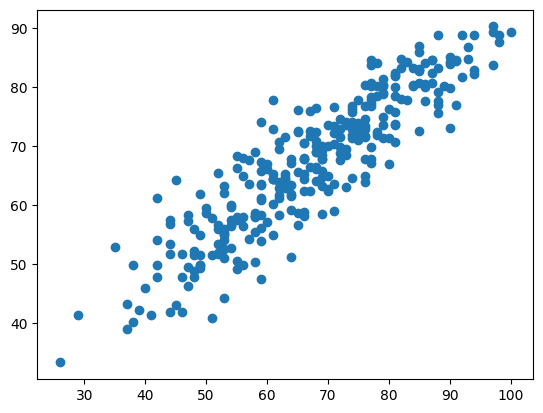

In [74]:
plt.scatter(y_test,y_pred_test)

<Axes: xlabel='math_score'>

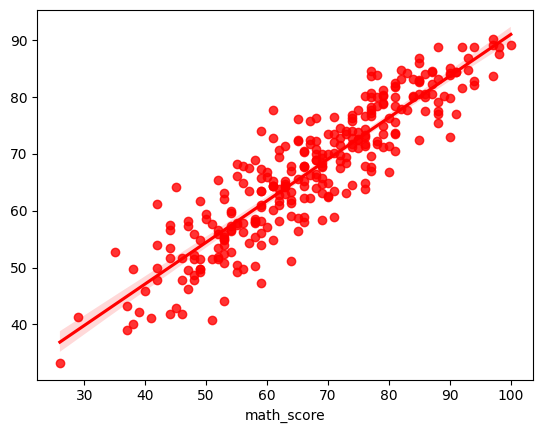

In [78]:
sns.regplot(x=y_test,y=y_pred_test,color="r")

In [79]:
pd.DataFrame({"Actual_Value": y_test, "Predicted_Value": y_pred_test,"Difference": y_test-y_pred_test})

,Actual_Value,Predicted_Value,Difference
778,72,72.763103,-0.763103
334,83,84.212633,-1.212633
271,58,50.303558,7.696442
802,87,84.582986,2.417014
216,83,77.727642,5.272358
...,...,...,...
652,85,83.065836,1.934164
720,62,63.868655,-1.868655
806,64,67.018818,-3.018818
570,71,73.425695,-2.425695
